In [1]:
from qiskit import *

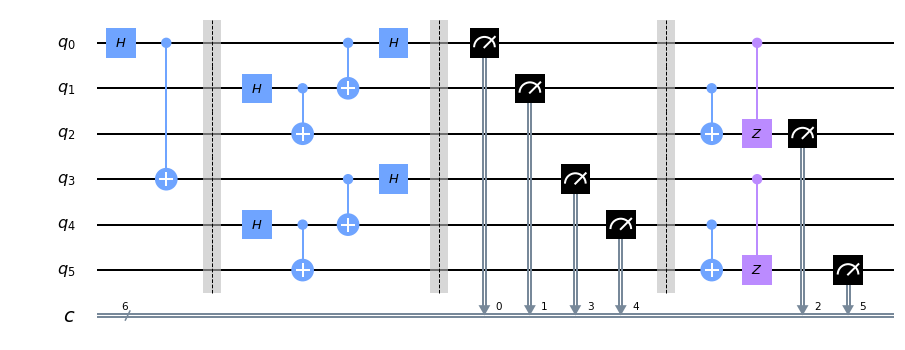

In [2]:
c = QuantumCircuit(6,6)

#make a pair of entangled qbits that will individually be teleported following the protocol
c.h(0)
c.cx(0,3)
c.barrier()

#now we create entanglement between Bob's two qbits
c.h(1)
c.cx(1,2)
c.h(4)
c.cx(4,5)

#we send qbit 1 to Alice from Bob then entangle it with psi
c.cx(0,1)
c.h(0)
c.cx(3,4)
c.h(3)
c.barrier()

#now we want to measure the two qbits that Alice has and use that info
#to change Bob's remaining qbit in a clever way that psi is now Bob's!

#first need to store measurements into classical bits
c.measure([0,1,3,4],[0,1,3,4])
c.barrier()

#now we can condition the operations Bob does on his qbit from the results
c.cx(1,2)
c.cz(0,2)
c.cx(4,5)
c.cz(3,5)

#finally we measure Bob's qbit
c.measure([2,5],[2,5])

c.draw(output='mpl')

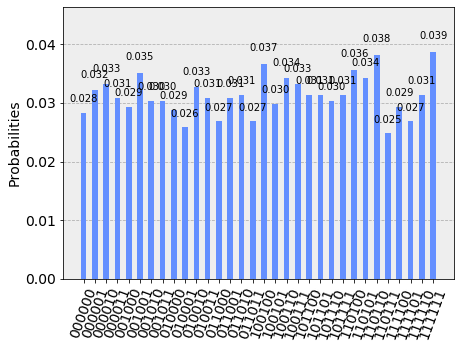

In [3]:
#now we will simulate the circuit built on Aer
simulator = Aer.get_backend('qasm_simulator')
sres = execute(c, backend = simulator, shots = 2048).result()
from qiskit.visualization import plot_histogram
plot_histogram(sres.get_counts(c))

In [4]:
#now we load the account we have that can run this on a real QM computer
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibmq_16_melbourne')

Job Status: job has successfully run


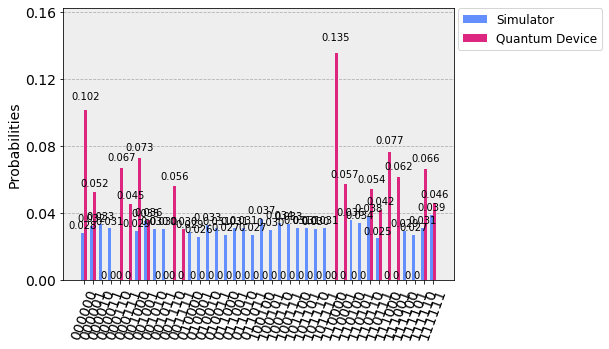

In [5]:
# run the job on the backend qcomp
job = execute(c, backend=qcomp, shots=2048)
from qiskit.tools.monitor import job_monitor
job_monitor(job)


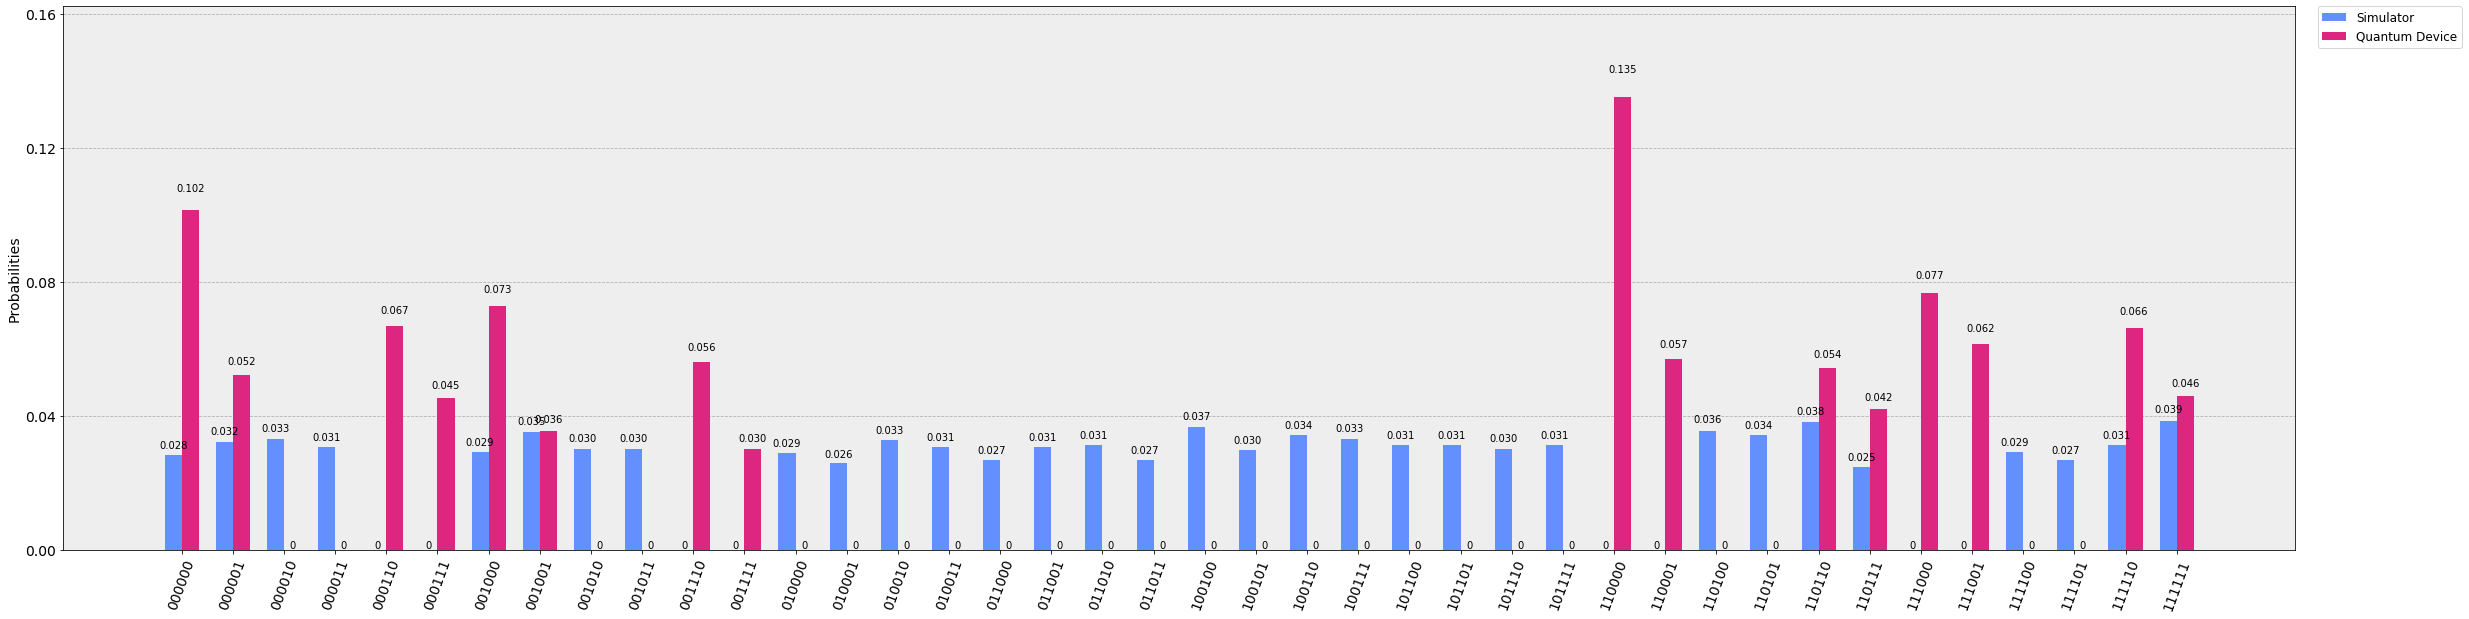

In [14]:

#plotting the result of the computation on quantum device
qres = job.result()
plot_histogram([sres.get_counts(c),qres.get_counts(c)], legend = ['Simulator','Quantum Device'], figsize=(40,10))

Job Status: job has successfully run


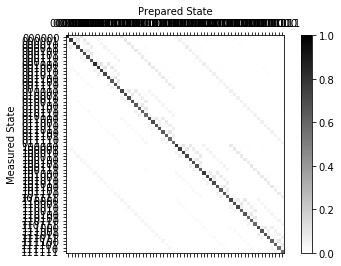

In [6]:
#noise mitigation
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

cal_circuits, state_labels = complete_meas_cal(qr = c.qregs[0], circlabel = 'measerrormitcal')
cal_job = execute(cal_circuits,
                 backend = qcomp,
                 shots = 1024,
                 optimization_level = 0,
                 )

#this part runs the predefined calibration circuits for the circuit size and monitors the job
job_monitor(cal_job)
calres = cal_job.result()

#we use the calibration result to filter out our noisy results
meas_fitter = CompleteMeasFitter(calres, state_labels)

#filtering out noise from the quantum result
meas_fitter.plot_calibration()
meas_filter = meas_fitter.filter
mitres = meas_filter.apply(qres)

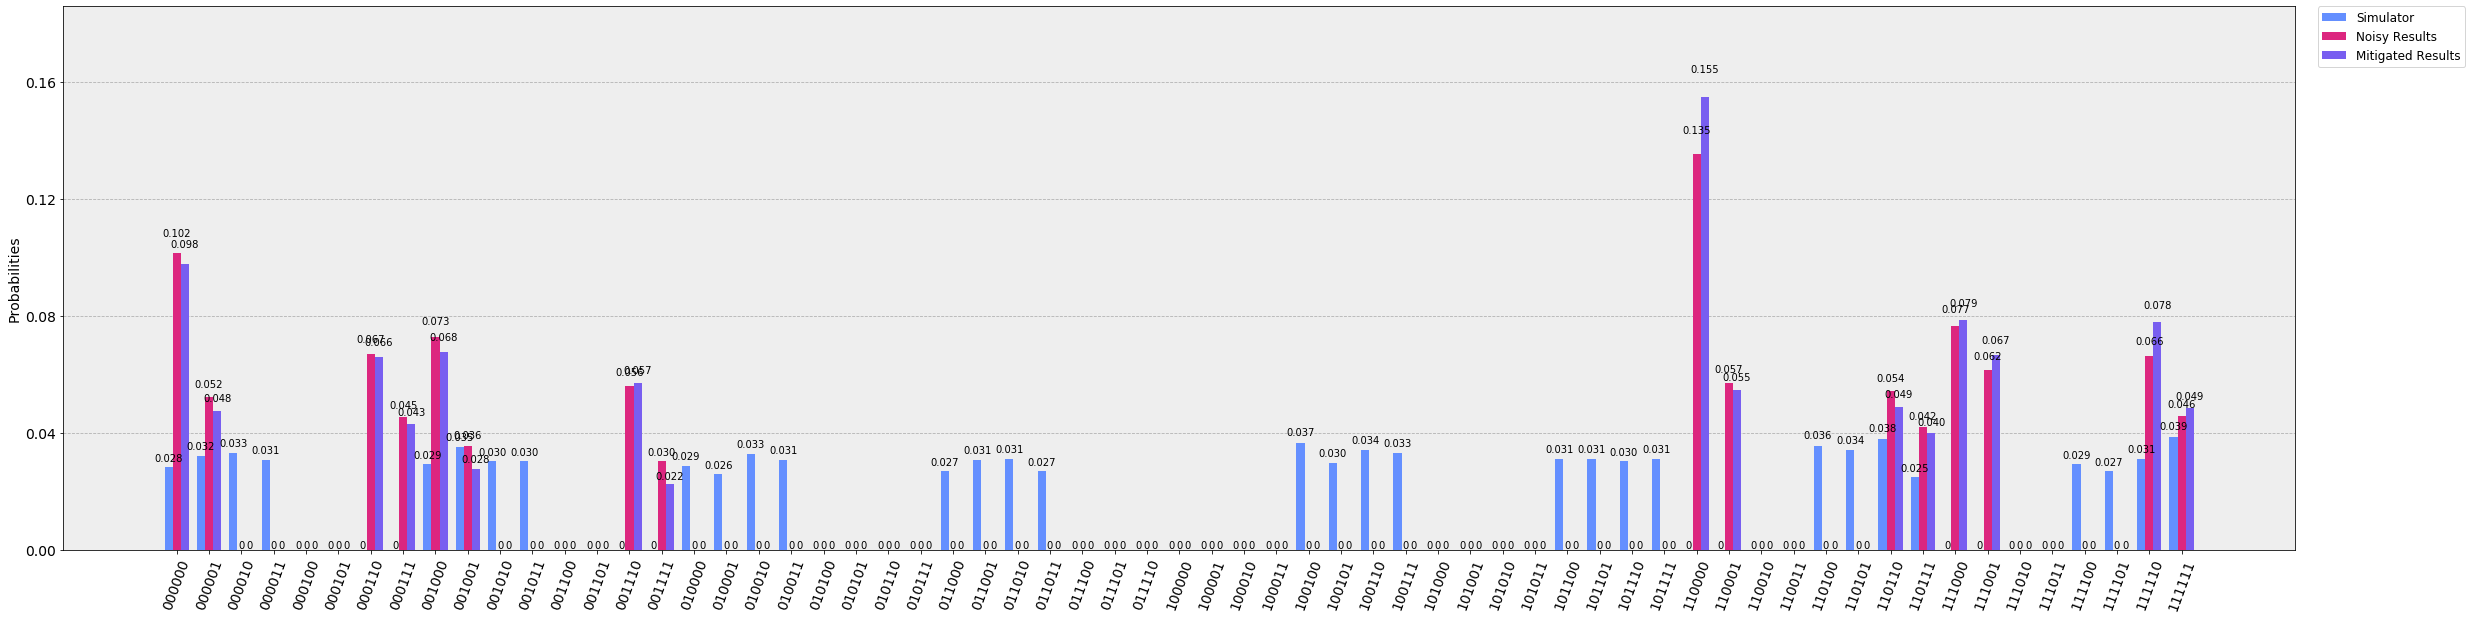

In [12]:
#plotting the sim vs noisy results vs mitigated results
qcounts = qres.get_counts(c)
mitcounts = mitres.get_counts(c)
plot_histogram([sres.get_counts(c), qres.get_counts(c), mitcounts], legend = ['Simulator', 'Noisy Results', 'Mitigated Results'], figsize=(40, 10))